### Chapter 15 ML Engineering in Action
Author: Ben Wilson

##### Overview
This notebook is simply the source code for generating the plots used in section 15.3 for the scenario being used. We clearly aren't going to be actually building the Siamese network here since music not in the public domain is hard to come by. I'm just including the generation of these images here for reference in case you're curious.

##### NOTE
These fourier transforms are pretty memory and CPU intensive. If you don't allocate more resources to the docker container running this, your kernel will likely crash. I recommend at least 6GB of memory and 4 cores if you'd like to play around with this code.

In [1]:
%pip install audio2numpy

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
import matplotlib.pyplot as plt
import numpy as np
import audio2numpy
import librosa
import librosa.display
from collections import namedtuple

In [4]:
beethoven_url = "https://freemusicarchive.org/track/Beethoven_-_Sonata_No_31_in_A_Flat_Major_Op_110_-_I_Moderato_cantabile_molto_espressivo/download"
mozart_url = "https://freemusicarchive.org/track/Advent_Chamber_Orchestra_-_04_-_Mozart_-_A_Little_Night_Music_allegro/download"

In [5]:
def download_classical(url, file_name):
    response = requests.get(url, stream=True)
    with open(file_name, "wb") as song:
        song.write(response.content)
    response.close()

def get_audio_file(file_name):
    Song = namedtuple('Song', 'data sample_rate')
    data, sr = audio2numpy.audio_from_file(file_name)
    return Song(data, sr)

def download_and_return_audio(url, file_name):
    download_classical(url, file_name)
    return get_audio_file(file_name)

def get_audio_channels(song_data, sample=5000000):
    Channels = namedtuple('Channels', 'left right sample_rate')
    left = song_data.data[:,0][:sample]
    right = song_data.data[:,1][:sample]
    return Channels(left, right, song_data.sample_rate)

def extract_mel_spec(channel_data, sample_rate, mels=128, fmax=12000):
    Mel = namedtuple('Mel', 'S dB')
    S = librosa.feature.melspectrogram(y=channel_data, sr=sample_rate, n_mels=mels, fmax=fmax)
    dB = librosa.power_to_db(S, ref=np.max)
    return Mel(S, dB)

def extract_db_scale(channel_data):
    return librosa.amplitude_to_db(np.abs(librosa.stft(channel_data)), ref=np.max)

def generate_spectrogram(channel_data, sample_rate, piece_name, mels=128, fmax=22000):
    with plt.style.context('seaborn'):
        fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(12,8))
        harmonic, percussion = librosa.effects.hpss(channel_data)
        librosa.display.waveshow(harmonic, sr=sample_rate, alpha=0.5, ax=ax[0], label="Harmonic")
        librosa.display.waveshow(percussion, sr=sample_rate, alpha=0.5, ax=ax[0], label="Percussion")
        ax[0].set(title=f"Harmonic and Percussive Waveforms for {piece_name}")
        ax[0].legend(loc='best')
        ax[0].set_ylim([-1.0, 1.0])
        mel = extract_mel_spec(channel_data, sample_rate, mels, fmax)
        librosa.display.specshow(mel.S, x_axis='time', y_axis='mel', sr=sample_rate, fmax=fmax, ax=ax[1])
        ax[1].set(title=f"Mel spectrogram for {piece_name}")
        img = librosa.display.specshow(extract_db_scale(channel_data), y_axis='linear', x_axis='time', 
                                       sr=sample_rate, ax=ax[1])
        fig.colorbar(img, ax=ax, format="%+2.f dB")
        plt.savefig(f"{piece_name}_spec.svg", format='svg', pad_inches=0)
        plt.savefig(f"{piece_name}_spec.png", format='png', pad_inches=0)

In [6]:
beethoven = download_and_return_audio(beethoven_url, "beethoven.mp3")
mozart = download_and_return_audio(mozart_url, "mozart.mp3")

In [7]:
beethoven_channels = get_audio_channels(beethoven, sample=2000000)
mozart_channels = get_audio_channels(mozart, sample=2000000)

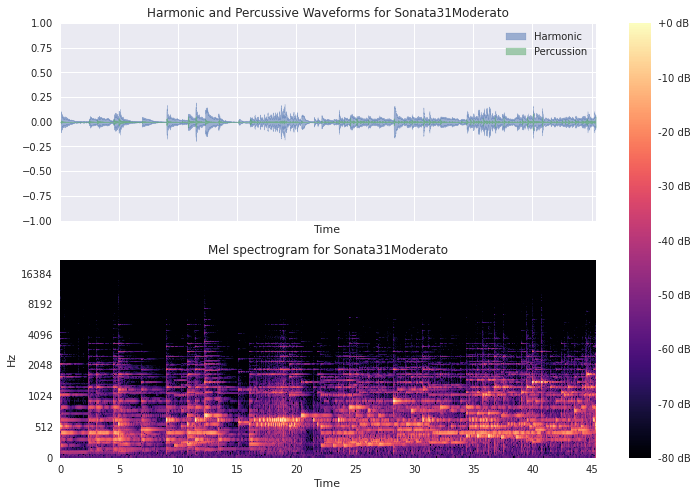

In [8]:
generate_spectrogram(beethoven_channels.left, beethoven_channels.sample_rate, "Sonata31Moderato")

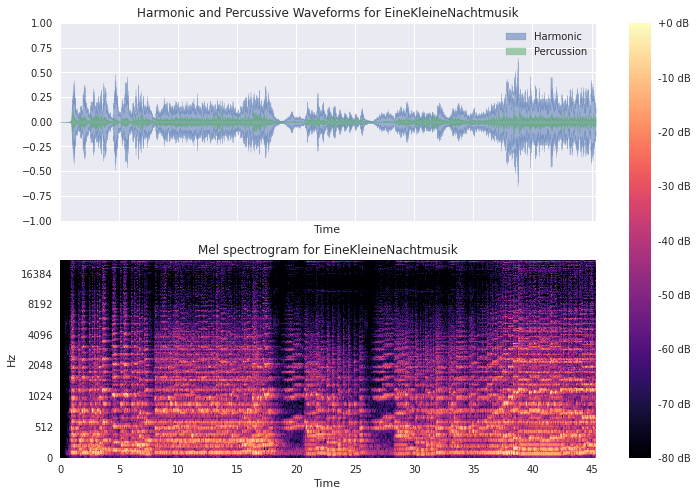

In [9]:
generate_spectrogram(mozart_channels.left, mozart_channels.sample_rate, "EineKleineNachtmusik")